<a href="https://colab.research.google.com/github/Pumafi/dl_spatial_gen_geol_facies/blob/main/ScoreBased_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Score-Based Generative Modeling (Tensorflow)

Translation of "Generative Modeling by Estimating Gradients of the Data Distribution" by Yang Song from PyTorch to Tensorflow 

Source Tutorial : https://yang-song.net/blog/2021/score/

Source PyTorch code : https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=YyQtV7155Nht

In [1]:
!pip install tqdm -U
!python3 -m pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import math

## Model

In [3]:
@tf.function
def marginal_prob_std(t, sigma=25.):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
      t: A vector of time steps.
      sigma: The $\sigma$ in our SDE.  
    
    Returns:
      The standard deviation.
    """
    return tf.math.sqrt((sigma**(2 * t) - 1.) / 2 / tf.math.log(sigma))

In [13]:
class GaussianFourierProjection(tf.keras.layers.Layer):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = self.add_weight(shape=(embed_dim // 2,),
                                 trainable=False,
                                 initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.), name="GFP") * tf.constant(scale, dtype=tf.float32)
    
    @tf.function
    def call(self, x):
        x_proj = tf.expand_dims(x, axis=-1) * tf.expand_dims(self.W, axis=0) * tf.constant(2., dtype=tf.float32) * tf.constant(np.pi, dtype=tf.float32)
        y = tf.concat([tf.math.sin(x_proj), tf.cos(x_proj)], axis=-1)
        return y # Probleme vient pas de là :()

class CustomLinear(tf.keras.layers.Layer):
    """Rhaaah."""  
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.W = tf.random.uniform((input_dim, output_dim), minval=-tf.math.sqrt(1/input_dim), maxval=tf.math.sqrt(1/input_dim))
        self.b = tf.random.uniform((1, output_dim, ), minval=-tf.math.sqrt(1/input_dim), maxval=tf.math.sqrt(1/input_dim))
    
    @tf.function
    def call(self, x):
        y = tf.tensordot(x, self.W, 1) + self.b

        return y


class DenseFeatures(tf.keras.layers.Layer):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.dense = CustomLinear(input_dim, output_dim)

    @tf.function
    def call(self, x):
        y = self.dense(x)
        return tf.expand_dims(tf.expand_dims(y, axis=1), axis=1)

# TODO : Dense that can be used in convolutions ? Concat ?
# ==> Used to apply to channels

@tf.function
def ScoreActivation(x):
    return x * tf.math.sigmoid(x)

class ScoreNet(tf.keras.Model):
    """A time-dependent score-based model built upon U-Net architecture."""
    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()

        # Layers
        ## Gaussian random features embedding layer for time
        self.embeding = tf.keras.Sequential([GaussianFourierProjection(embed_dim=embed_dim),
                                             CustomLinear(embed_dim, embed_dim)]) # Problem vient de la Dense ?
        
        # Dimension Reduction
        self.conv1 = tf.keras.layers.Conv2D(channels[0], (3, 3), strides=1, use_bias=False)
        self.dense1 = DenseFeatures(embed_dim, channels[0])
        self.gnorm1 = tfa.layers.GroupNormalization(4, epsilon=1e-05)

        self.conv2 = tf.keras.layers.Conv2D(channels[1], (3, 3), strides=2, use_bias=False)
        self.dense2 = DenseFeatures(embed_dim, channels[1])
        self.gnorm2 = tfa.layers.GroupNormalization(32, epsilon=1e-05)

        self.conv3 = tf.keras.layers.Conv2D(channels[2], (3, 3), strides=2, use_bias=False)
        self.dense3 = DenseFeatures(embed_dim, channels[2])
        self.gnorm3 = tfa.layers.GroupNormalization(32, epsilon=1e-05)

        self.conv4 = tf.keras.layers.Conv2D(channels[3], (3, 3), strides=2, use_bias=False)
        self.dense4 = DenseFeatures(embed_dim, channels[3])
        self.gnorm4 = tfa.layers.GroupNormalization(32, epsilon=1e-05)

        # Dimension Reconstruction
        self.tconv4 = tf.keras.layers.Conv2DTranspose(channels[2], (3, 3), strides=2, use_bias=False)
        self.tdense4 = DenseFeatures(embed_dim, channels[2])
        self.tgnorm4 = tfa.layers.GroupNormalization(32, epsilon=1e-05)

        self.tconv3 = tf.keras.layers.Conv2DTranspose(channels[1], (3, 3), strides=2, use_bias=False, output_padding=1)
        self.tdense3 = DenseFeatures(embed_dim, channels[1])
        self.tgnorm3 = tfa.layers.GroupNormalization(32, epsilon=1e-05)

        self.tconv2 = tf.keras.layers.Conv2DTranspose(channels[0], (3, 3), strides=2, use_bias=False, output_padding=1)
        self.tdense2 = DenseFeatures(embed_dim, channels[0])
        self.tgnorm2 = tfa.layers.GroupNormalization(32, epsilon=1e-05)
        # Gradient explosion lol
        self.tconv1 = tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=1)

        #self.act = ScoreActivation() 

    @tf.function
    def call(self, x, t): 
      # Obtain the Gaussian random feature embedding for t
      embed = ScoreActivation(self.embeding(t))

      # Encoding path
      h1 = self.conv1(x) 
      ## Incorporate information from t
      h1 += self.dense1(embed)
      ## Group normalization
      h1 = self.gnorm1(h1)
      h1 = ScoreActivation(h1)
      h2 = self.conv2(h1)
      h2 += self.dense2(embed)
      h2 = self.gnorm2(h2)
      h2 = ScoreActivation(h2)
      h3 = self.conv3(h2)
      h3 += self.dense3(embed)
      h3 = self.gnorm3(h3)
      h3 = ScoreActivation(h3)
      h4 = self.conv4(h3)
      h4 += self.dense4(embed)
      h4 = self.gnorm4(h4)
      h4 = ScoreActivation(h4)

      # Decoding path
      h = self.tconv4(h4)
      ## Skip connection from the encoding path
      h += self.tdense4(embed)
      h = self.tgnorm4(h)
      h = ScoreActivation(h)

      h = self.tconv3(tf.concat([h, h3], axis=-1))
      h += self.tdense3(embed)
      h = self.tgnorm3(h)
      h = ScoreActivation(h)

      h = self.tconv2(tf.concat([h, h2], axis=-1))
      h += self.tdense2(embed)
      h = self.tgnorm2(h)
      h = ScoreActivation(h)

      h = self.tconv1(tf.concat([h, h1], axis=-1))

      # Normalize output
      h = h / marginal_prob_std(tf.reshape(t, (x.shape[0], 1, 1, 1)), 25.)
      h = tf.reshape(h, x.shape)
      return h

## Setting up the SDE

In [14]:
import functools

@tf.function
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  return tf.math.sqrt((sigma**(2 * t) - 1.) / 2. / tf.math.log(sigma))

@tf.function
def diffusion_coeff(t, sigma=25.):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return sigma**t

sigma =  25.0# @param {'type':'number'}


# marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
# diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [15]:
# std is clear
# y not okay
# 
import time

In [16]:

@tf.function
def loss_fn(model, x, eps=1e-5, sigma=25.):
    random_t = tf.random.uniform((x.shape[0],), minval=0., maxval=1.0) * tf.constant((1. - eps) + eps, dtype=tf.float32)
    z = tf.random.normal(x.shape)
    std = marginal_prob_std(random_t, sigma=sigma)
    perturbed_x = x + z * tf.reshape(std, (-1, 1, 1, 1))
    score = model(perturbed_x, random_t)
    y = score * tf.reshape(std, (-1, 1, 1, 1))
    y = y + z
    loss = tf.math.reduce_mean(tf.reduce_sum(y**2, axis=[1, 2, 3]))
    return loss, y, score

## Loading the data

In [17]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train.astype("float32") / 255, axis=-1)
x_test = np.expand_dims(x_test.astype("float32") / 255, axis=-1)

In [18]:
x_train.shape

(60000, 28, 28, 1)

## Training

In [19]:
import tqdm

In [20]:
from tqdm import notebook

In [21]:
n_epochs=50#@param {'type':'integer'}

## learning rate
lr=1e-4 #@param {'type':'number'}

score_model = ScoreNet()

optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr)
tqdm_epoch = notebook.trange(n_epochs) #tqdm.notebook.trange(n_epochs)
sigma = 25.#@param {'type':'number'}

## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, _ in train_dataset:

        with tf.GradientTape() as tape:
            loss, y, score = loss_fn(score_model, x, sigma)


        avg_loss += loss.numpy() * x.shape[0]
        num_items += x.shape[0]

        gradients = tape.gradient(loss, score_model.trainable_variables)

        optimizer.apply_gradients(zip(gradients, score_model.trainable_variables))
    print(loss.numpy().mean(), y.numpy().mean(), score.numpy().mean())

    tqdm_epoch.set_description('Average Loss: {:4f}, '.format(avg_loss / num_items))


  0%|          | 0/50 [00:00<?, ?it/s]

64.063896 -0.00028398298 -0.008270503
44.492527 -0.010746598 -0.016309839
46.712944 -0.0008928486 0.0010253928
24.690744 -0.0032162163 -0.012530256
33.010498 0.014222149 0.0038337647
17.166224 0.0030049125 -0.000950359
31.233677 0.0050856434 0.014186354
29.024113 0.0100424485 0.030704776
27.477074 -0.0078982795 -0.016324637
35.46295 -0.0014318251 -0.003485739
23.039616 -0.00090915535 -0.002615865
17.733921 -0.002598048 0.0027811301
23.891027 0.002011288 -0.011582545
17.021526 -0.0034121745 -0.0020659512
20.34732 -0.007832976 0.0042666607
24.980766 0.006097951 0.013243353
18.928633 0.0027785283 0.0056946515
15.976973 0.0013906101 0.00808453
21.21794 0.0030890591 0.007545429
32.529587 -0.0030555136 -0.018238708


KeyboardInterrupt: ignored

## Sampling

In [22]:
def Euler_Maruyama_sampler(score_model,
                           batch_size=64, 
                           num_steps=500,
                           sigma=25.,
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
      score_model: A PyTorch model that represents the time-dependent score-based model.
      marginal_prob_std: A function that gives the standard deviation of
        the perturbation kernel.
      batch_size: The number of samplers to generate by calling this function once.
      num_steps: The number of sampling steps. 
        Equivalent to the number of discretized time steps.
      device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
      eps: The smallest time step for numerical stability.
    
    Returns:
      Samples.    
    """
    t = tf.ones((batch_size,), dtype=tf.float32)
    std = marginal_prob_std(t, sigma)
    init_x = z = tf.random.normal((batch_size, 28, 28, 1)) * tf.reshape(std, (-1, 1, 1, 1))
    time_steps = tf.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    for time_step in tqdm.notebook.tqdm(time_steps):   
        batch_time_step = tf.ones((batch_size,), dtype=tf.float32) * time_step
        g = diffusion_coeff(batch_time_step, sigma=sigma)
        mean_x = x + tf.reshape(g**2, (-1, 1, 1, 1)) * score_model(x, batch_time_step) * step_size
        x = mean_x + tf.math.sqrt(step_size) * tf.reshape(g, (-1, 1, 1, 1)) * tf.random.normal(x.shape)
    return mean_x

In [23]:
def pc_sampler(score_model,
               batch_size=64, 
               num_steps=500, 
               signal_to_noise_ratio=0.16,
               sigma=25.,
               eps=1e-3):
    t = tf.ones((batch_size,), dtype=tf.float32)
    std = marginal_prob_std(t, sigma)
    init_x = tf.random.normal((batch_size, 28, 28, 1)) * tf.reshape(std, (-1, 1, 1, 1))
    time_steps = tf.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    for time_step in tqdm.notebook.tqdm(time_steps):   
        batch_time_step = tf.ones((batch_size,), dtype=tf.float32) * time_step
        grad = score_model(x, batch_time_step) 
        grad_norm = tf.math.reduce_mean(tf.norm(tf.reshape(grad, (grad.shape[0], -1)), axis=-1))
        noise_norm = np.sqrt(np.prod(x.shape[1:]))
        langevin_step_size = 2 * (signal_to_noise_ratio * noise_norm / grad_norm)**2
        x = x + langevin_step_size * grad + tf.math.sqrt(2 * langevin_step_size) *  tf.random.normal(x.shape)
        g = diffusion_coeff(batch_time_step, sigma=sigma)
        mean_x = x + tf.reshape(g**2, (-1, 1, 1, 1)) * score_model(x, batch_time_step) * step_size
        x = mean_x + tf.reshape(tf.math.sqrt(g**2 * step_size), (-1, 1, 1, 1)) * tf.random.normal(x.shape)
    return mean_x

In [24]:
from scipy import integrate

def ode_sampler(score_model,
                batch_size=64, 
                atol=1e-5, 
                rtol=1e-5,
                sigma=25.,
                z=None,
                eps=1e-3):
    t = tf.ones((batch_size,), dtype=tf.float32)
    if z is None:
        std = marginal_prob_std(t, sigma)
        init_x = tf.random.normal((batch_size, 28, 28, 1)) * tf.reshape(std, (-1, 1, 1, 1))
    else:
        init_x = z

    shape = init_x.shape

    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = tf.reshape(sample, shape)
        time_steps = tf.reshape(time_steps, (sample.shape[0], ))
        score = score_model(sample, time_steps)
        return score.numpy().reshape(-1,) #.astype(np.float64)

    def ode_func(t, x):
        time_steps = np.ones((shape[0],), dtype='float32') * t
        g = diffusion_coeff(t).numpy()
        return -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
    
    res = integrate.solve_ivp(ode_func, (1., eps), tf.reshape(init_x, (-1,)).numpy(), rtol=rtol, atol=atol, method='RK45')
    print(f"Number of function evaluations: {res.nfev}")
    x = res.y[:, -1].reshape(shape)
    return x  

In [25]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.

sample_batch_size = 64 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  sample_batch_size,)

  0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
samples.shape

TensorShape([64, 28, 28, 1])

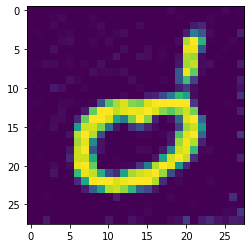

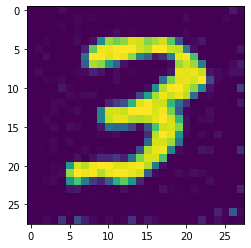

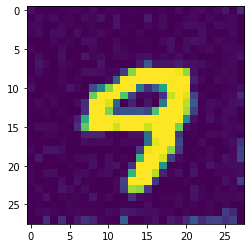

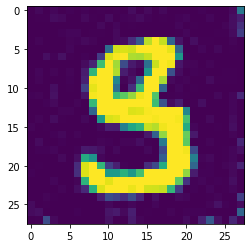

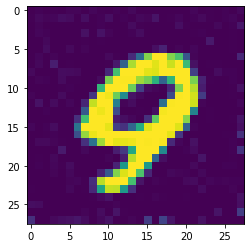

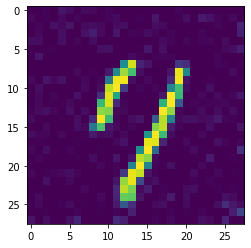

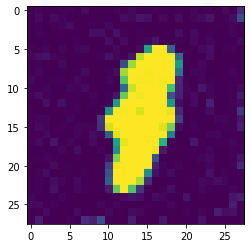

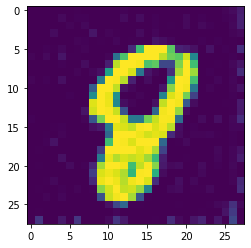

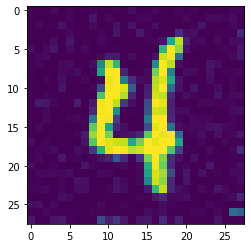

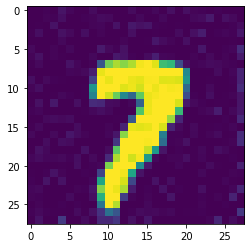

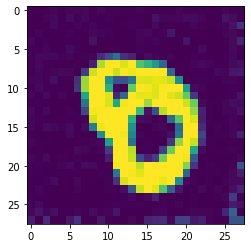

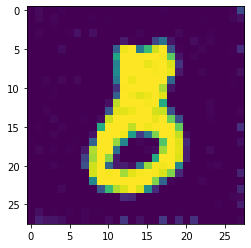

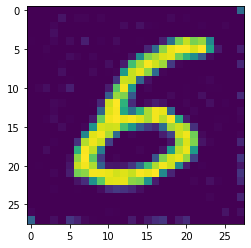

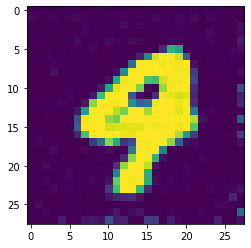

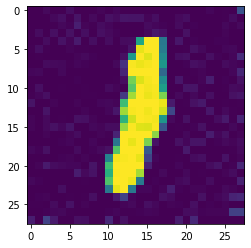

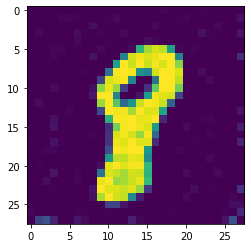

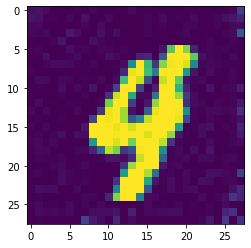

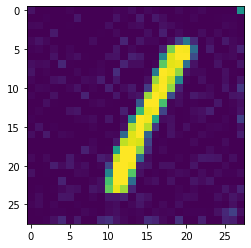

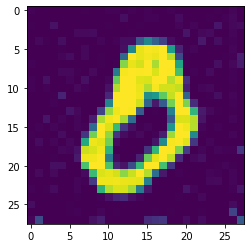

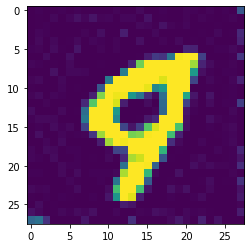

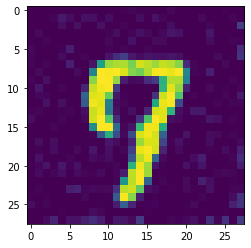

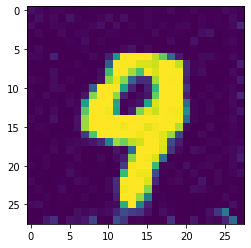

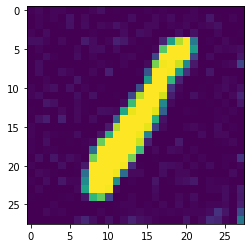

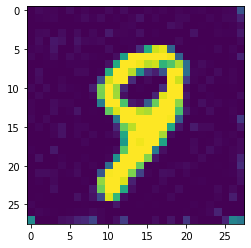

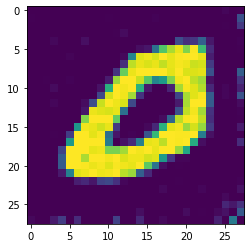

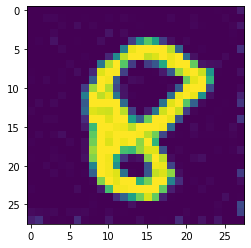

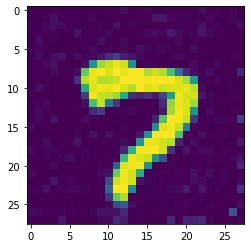

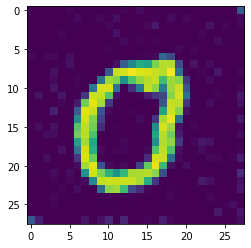

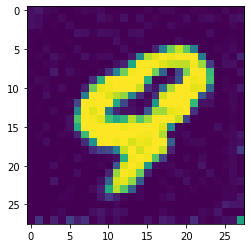

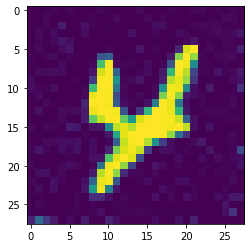

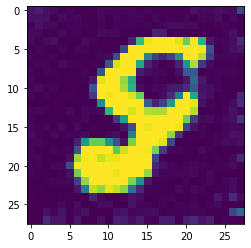

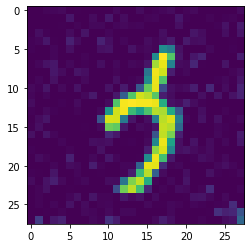

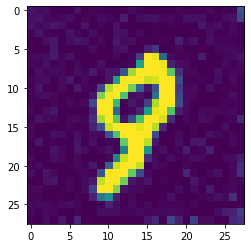

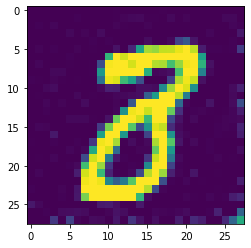

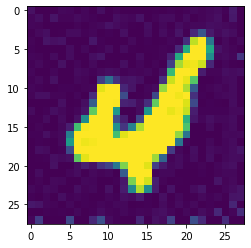

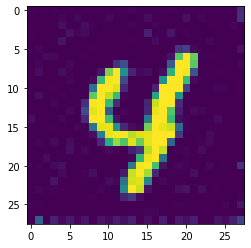

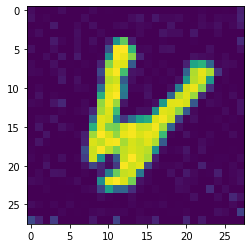

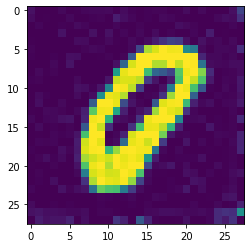

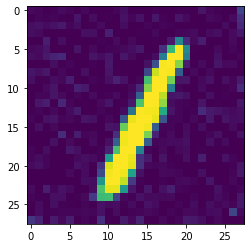

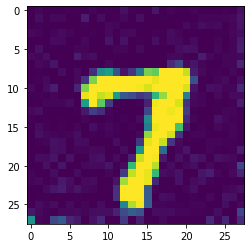

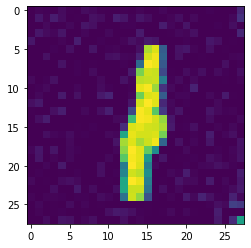

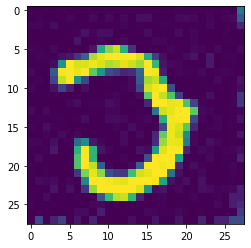

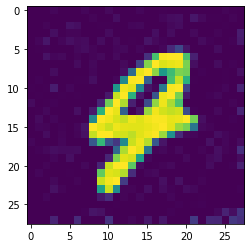

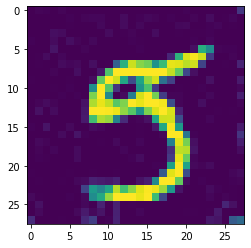

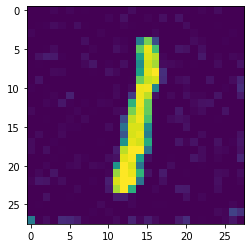

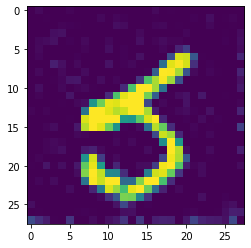

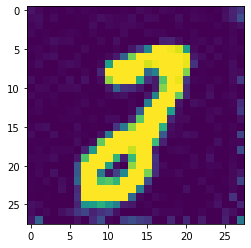

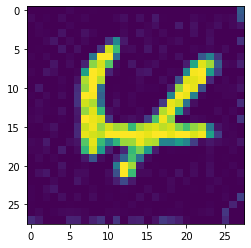

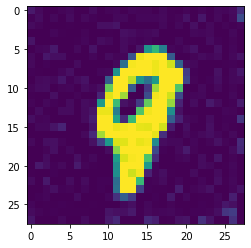

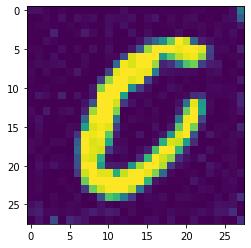

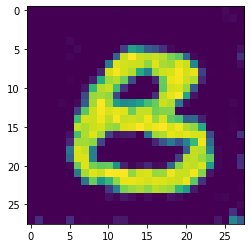

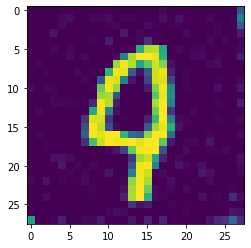

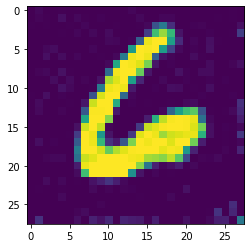

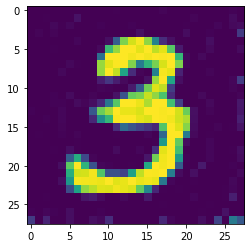

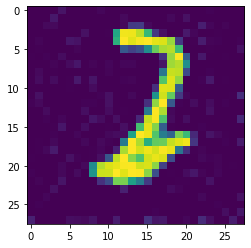

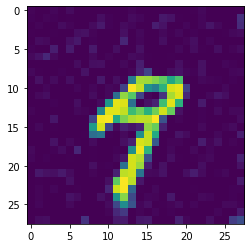

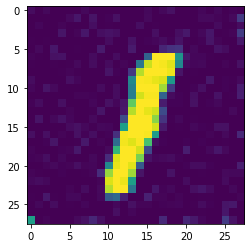

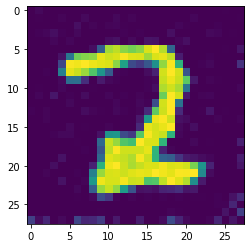

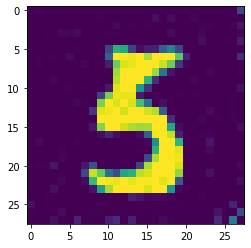

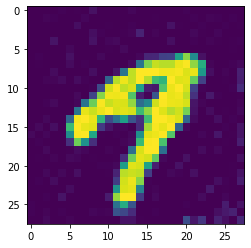

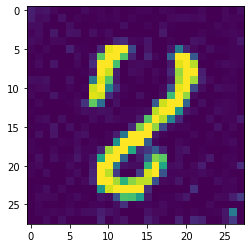

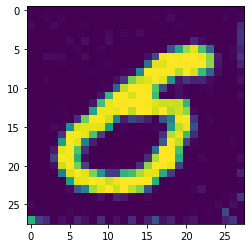

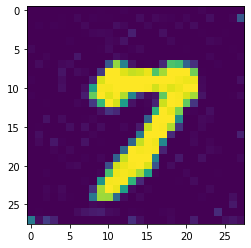

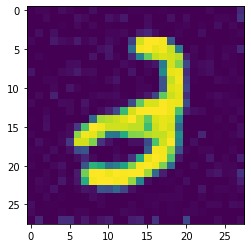

In [27]:
import matplotlib.pyplot as plt
for img in  samples:
    plt.imshow(img, vmin=0., vmax=1.)
    plt.show()